# Predicting World Cup 2014

Let's build a model that uses score differentials from initial stages of World Cup 2014 as data. Additionally, we will fit the model on square-root scale as extra goals don’t provide as much information when the game is not close.

## Data

Our data contains the results of 62 matches, collected from the start of the World Cup upto 13 July 2014. Since our data is small, we will use the Soccer Power Index (from back then) as prior information about each team.

## Model

If team $i$ and team $j$ are playing and score $y_i$ and $y_j$ goals, then the data point for this game is $y_{ij} = sign(y_i - y_j)*\sqrt{|y_i-y_j|}$, and the data model is:

$$y_{ij} \sim Normal(a_i-a_j, \sigma{y})$$

where $a_i$ and $a_j$ are the ability parameters for the two teams and $\sigma{y}$ is a scale parameter estimated from the data.

We will use a $t$ distribution as our data contains some outliers (eg Germany - Brazil match):

$$y_{ij} \sim t_{df}(a_i-a_j, \sigma{y})$$

setting the degrees of freedom to df=7 which has been occasionally recommended as a robust alternative to the normal.

Given our prior information based on the Soccer Power Index (SPI), the model for each team ability is (relative to others):

$$a_i \sim Normal(b * \text{SPI}_i, \sigma{a})$$

where $b$, $\sigma{y}$, $\sigma{a}$ are model parameters.

In [23]:
library(tidyverse)
library(ggthemes) # visualization
library(rstan)
library(bayesplot)
library(arm)
library(tidybayes)

theme_update(plot.title = element_text(hjust = 0.5))

teams <- as.vector (unlist (read.table ("soccerpowerindex.txt", header=FALSE)))
nteams <- length(teams)
prior_score <- rev(1:nteams)
prior_score <- (prior_score - mean(prior_score))/(2*sd(prior_score))

data2012 <- read.table ("worldcup2012.txt", header=FALSE)
ngames <- nrow (data2012)

team1 <- match (as.vector(data2012[[1]]), teams)
score1 <- as.vector(data2012[[2]])
team2 <- match (as.vector(data2012[[3]]), teams)
score2 <- as.vector(data2012[[4]])

df <- 7

data <- c("nteams","ngames","team1","score1","team2","score2","prior_score","df")

In [4]:
fit <- stan("worldcup_model.stan", data=data, chains=4, iter=1000)

In file included from file12dc258ddc2c0.cpp:8:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/src/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/mat.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core.hpp:12:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core/var.hpp:7:
In file included from /usr/local/lib/R/3.4/site-library/BH/include/boost/math/tools/config.hpp:13:
In file included from /usr/local/lib/R/3.4/site-library/BH/include/boost/config.hpp:39:
/usr/local/lib/R/3.4/site-library/BH/include/boost/config/compiler/clang.hpp:200:11: warning: 'BOOST_NO_CXX11_RVALUE_REFERENCES' macro r

In [25]:
fit

Inference for Stan model: worldcup_matt.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
b           0.94    0.00 0.18   0.56   0.82   0.94   1.06   1.29  2000    1
sigma_a     0.26    0.01 0.15   0.02   0.15   0.26   0.36   0.57   414    1
sigma_y     0.84    0.00 0.10   0.66   0.77   0.84   0.91   1.07  1137    1
eta_a[1]   -0.20    0.02 0.88  -1.98  -0.79  -0.22   0.37   1.49  2000    1
eta_a[2]    0.16    0.02 0.83  -1.57  -0.42   0.16   0.73   1.78  2000    1
eta_a[3]    0.58    0.02 0.89  -1.28  -0.02   0.60   1.19   2.26  2000    1
eta_a[4]   -0.61    0.02 0.98  -2.49  -1.28  -0.65   0.04   1.42  2000    1
eta_a[5]    0.05    0.02 0.86  -1.61  -0.54   0.06   0.65   1.67  2000    1
eta_a[6]    0.22    0.02 0.85  -1.47  -0.37   0.23   0.79   1.86  2000    1
eta_a[7]    0.53    0.02 0.86  -1.20  -0.05   0.53   1.08   2.18  2000    1
eta_a[8

The etas are the team-level residuals and the a's are team abilities. The group-level error sd sigma_a is estimated at 0.26 which indicates that our final estimates of team abilities are dominated by the power index. This is due to factors: initial ranking is accurate and there is just not enough data.

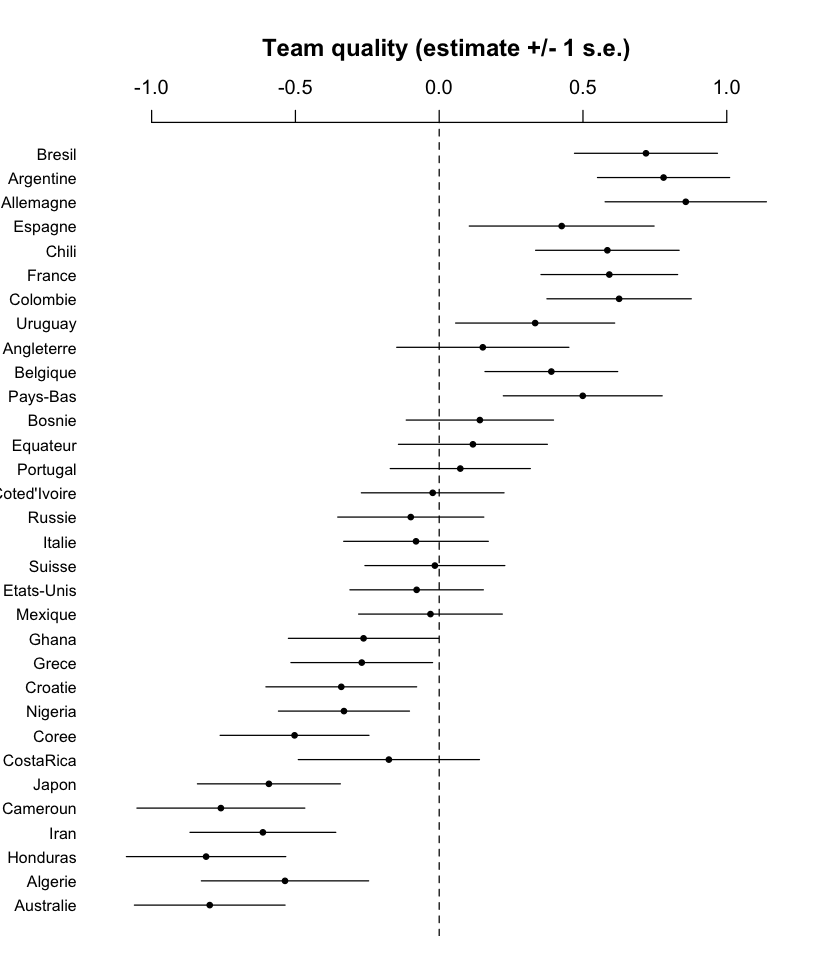

In [38]:
options(repr.plot.width=7, repr.plot.height=8)

colVars <- function(a) {n <- dim(a)[[1]]; c <- dim(a)[[2]]; return(.colMeans(((a - matrix(.colMeans(a, n, c), nrow = n, ncol = c, byrow = TRUE)) ^ 2), n, c) * n / (n - 1))}

plot_team_quality <- function(fit) {

    sims <- rstan::extract(fit)
    a_sims <- sims$a
    a_hat <- colMeans(a_sims)
    a_se <- sqrt(colVars(a_sims))
    coefplot(
        rev(a_hat), 
        rev(a_se), 
        CI=1,
        varnames=rev(teams), 
        main="Team quality (estimate +/- 1 s.e.)\n"
    )
}

plot_team_quality(fit)

In [39]:
fit_noprior <- stan("worldcup_noprior_model.stan", data=data, chains=4, iter=1000)

In file included from file12dc234f48e1f.cpp:8:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/src/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/mat.hpp:4:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core.hpp:12:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5:
In file included from /usr/local/lib/R/3.4/site-library/StanHeaders/include/stan/math/rev/core/var.hpp:7:
In file included from /usr/local/lib/R/3.4/site-library/BH/include/boost/math/tools/config.hpp:13:
In file included from /usr/local/lib/R/3.4/site-library/BH/include/boost/config.hpp:39:
/usr/local/lib/R/3.4/site-library/BH/include/boost/config/compiler/clang.hpp:200:11: warning: 'BOOST_NO_CXX11_RVALUE_REFERENCES' macro r

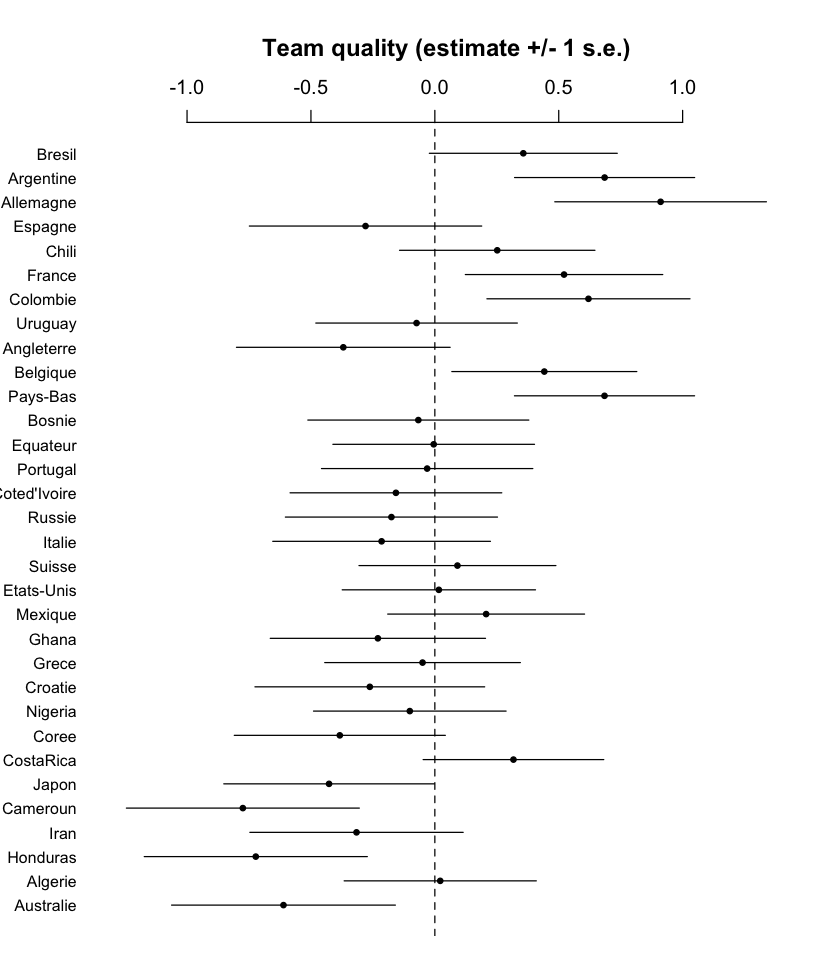

In [40]:
plot_team_quality(fit_noprior)

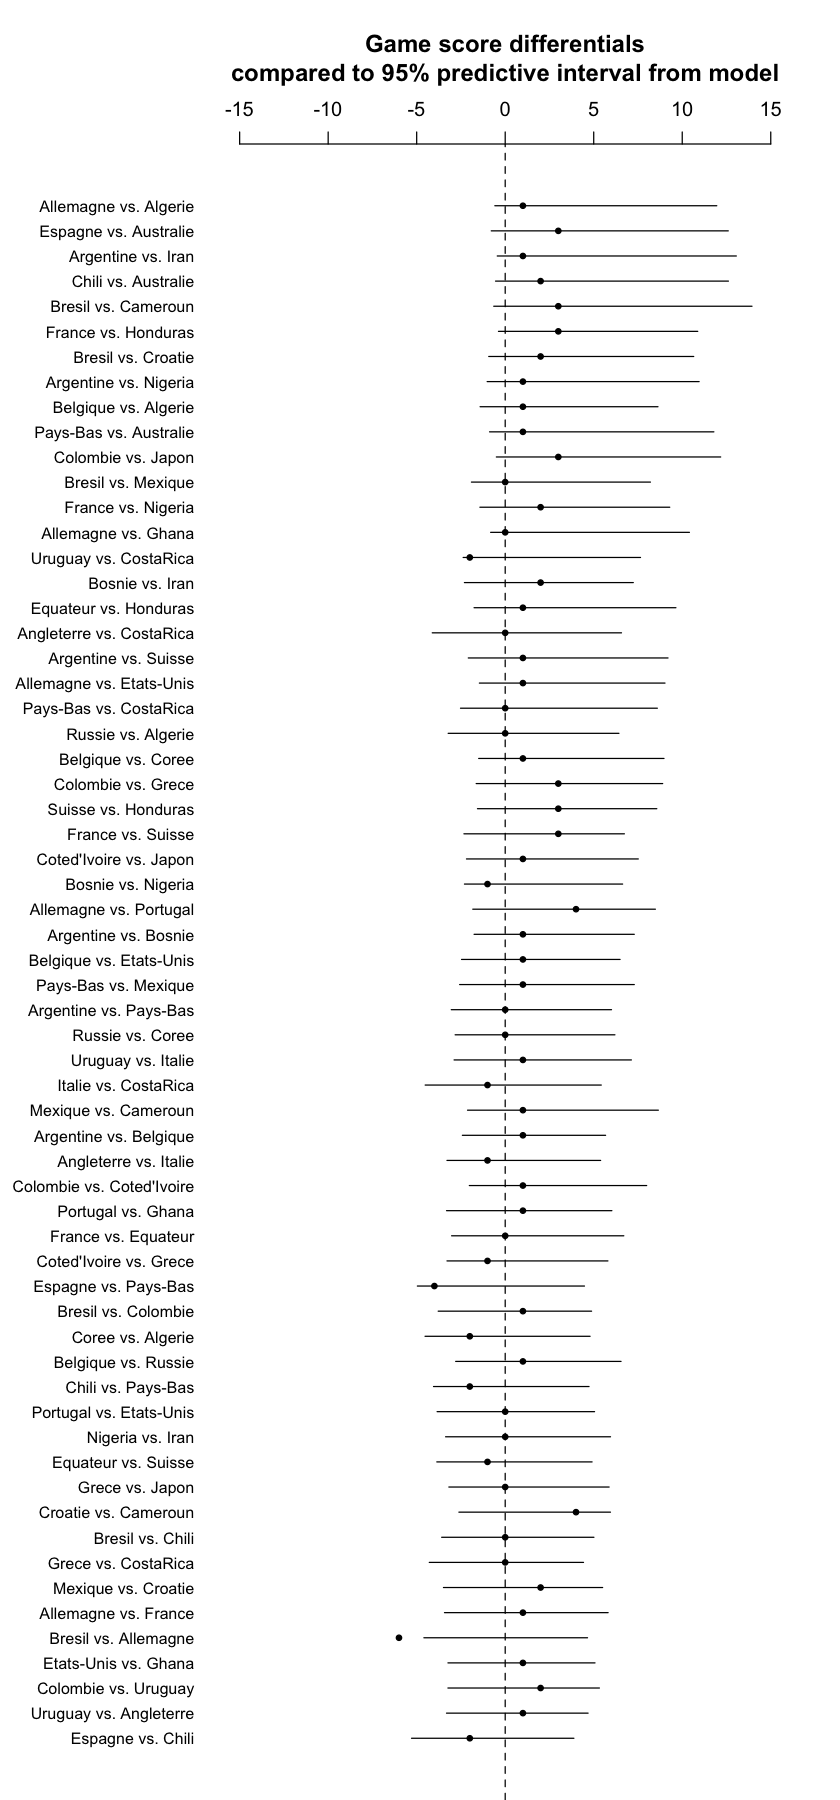

In [44]:
signed_square <- function (a) {sign(a)*a^2}

sims <- rstan::extract (fit)
a_sims <- sims$a
sigma_y_sims <- sims$sigma_y
nsims <- length(sigma_y_sims)
random_outcome <- array(NA, c(nsims,ngames))
for (s in 1:nsims){
  random_outcome_on_sqrt_scale <- (a_sims[s,team1] - a_sims[s,team2]) + rt(ngames,df)*sigma_y_sims[s]
  random_outcome[s,] <- signed_square(random_outcome_on_sqrt_scale)
}
sim_quantiles <- array(NA,c(ngames,2))
for (i in 1:ngames){
  sim_quantiles[i,] <- quantile(random_outcome[,i], c(.025,.975))
}

# Do it again, rounding the continuous predictions:

for (i in 1:ngames){
  sim_quantiles[i,] <- quantile(round(random_outcome[,i]), c(.025,.975))
}

# Reorder the games in order of predicted score differential
new_order <- order(prior_score[team1] - prior_score[team2])

for (i in 1:ngames){
  sim_quantiles[i,] <- quantile(random_outcome[,i], c(.025,.975))
}

# Flip so expected outcomes are always positive
flip <- ifelse (prior_score[team1] < prior_score[team2], -1, 1)
new_order <- order((prior_score[team1] - prior_score[team2])*flip)
flip <- flip[new_order]
options(repr.plot.width=7, repr.plot.height=15)

coefplot ((score1 - score2)[new_order]*flip, sds=rep(0, ngames),
          lower.conf.bounds=sim_quantiles[new_order,1]*flip, upper.conf.bounds=sim_quantiles[new_order,2]*flip, 
          varnames=ifelse(flip==1, paste(teams[team1[new_order]], "vs.", teams[team2[new_order]]),
                          paste(teams[team2[new_order]], "vs.", teams[team1[new_order]])),
          main="Game score differentials\ncompared to 95% predictive interval from model\n",
          mar=c(0,7,6,2), xlim=c(-15,15))